In [194]:
import pandas as pd
import numpy as np
import random
import timeit
import concurrent.futures
import matplotlib.pyplot as plt

In [195]:
true_probabilities = np.array([1/6,1/3,1/2,2/3,5/6])

In [196]:
def generate_n_seq_training_set(num_seq):
    training_data = []
    #states are abcdefg, always starts with d
    for i in range(num_seq):
        train_sequence = [3]
        #a is 0 and g is 6
        while train_sequence[-1] not in [0,6]:
            #-1 moves left, +1 moves right
            train_sequence = train_sequence+[train_sequence[-1]+[-1,1][random.randint(0,1)]]
        training_data = training_data+[np.array(train_sequence)]
    return(training_data)


In [197]:
def generate_balanced_n_seq_training_set(num_seq):
    last_end_state = 0
    training_data = []
    i = 0
    #states are abcdefg, always starts with d
    while i < num_seq:
        train_sequence = [3]
        #a is 0 and g is 6
        while train_sequence[-1] not in [0,6]:
            #-1 moves left, +1 moves right
            train_sequence = train_sequence+[train_sequence[-1]+[-1,1][int(np.random.rand()>=0.5)]]
        if train_sequence[-1] == last_end_state: 
            continue
        else:
            training_data = training_data+[np.array(train_sequence)]
            last_end_state = train_sequence[-1]
            i+=1
    return(training_data)


In [198]:
def tdlearn_a_sequence(train,lba,alpha,weights):
    train_steps = train[1:]
    x_learn_mat = np.zeros((len(train_steps)-1,5))
    #not learning the last step
    delta_weights = np.zeros(5)
    for i in range(len(train_steps)-1):
        #update the learn mat with current state value
        x_learn_mat[i,train_steps[i]-1] = 1
        #get current state and its x,p value
        current_state = train_steps[i]
        p_current_state = weights[current_state-1]
        # get next state and its p value
        next_state = train_steps[i+1]
        if next_state == 0: p_next_state = 0;
        elif next_state == 6: p_next_state = 1;
        else: p_next_state = weights[next_state-1];
        # p difference between next step and current step
        p_difference = p_next_state-p_current_state
        # x matrix for all steps from least recent to most recent
        all_steps_x_matrix = x_learn_mat[0:(i+1),:]
        # array of lambda power values for multiplication, from highest power to lowest power
        lba_array = np.array([lba**i for i in range(i+1)])[::-1]
        # delta in weights after this step
        delta_weights =  delta_weights+alpha * p_difference * np.sum((all_steps_x_matrix*lba_array[:,None]),axis = 0)
#         print('current_state:', current_state)
#         print('p_current_state:', p_current_state)
#         print('next_state:',next_state)
#         print('p_next_state:', p_next_state)
#         print('all_steps_x_matrix:', all_steps_x_matrix)
#         print('lba_array:', lba_array)
#         print('matrix product:', all_steps_x_matrix*lba_array[:,None])
#         print('p_difference:', p_difference)
#         print('delta_weights:', delta_weights)
    return delta_weights


In [199]:
#each set has 10 sequences
def figure_3_experiment_per_lambda(lba,alpha,train_data_full_set):
    rmse_array = np.array([])
    for i in range(100):
        #repeatedly train weights using a train set until convergence, 
        #update weights after finishing each iteration of train set
        train_data = train_data_full_set[i*10:i*10+10]
        weights = np.full(5,0.5)
        previous_weights = np.full(5,0.6)
        iterations = 0
        while np.any(np.absolute(weights-previous_weights)) > 0.0001:
            iterations += 1
            delta_weights = np.zeros(5)
            for j in train_data:
                delta_weights = delta_weights + tdlearn_a_sequence(train = j,lba = lba,alpha = alpha,weights = weights)
            #update weights and previous weights after one iteration of a training set
            previous_weights = weights
            weights = weights + delta_weights
            if(iterations > 2000): break;
            #print('iterations:', iterations)
        #converged, calculate rmse for this data set
        rmse = np.sqrt(np.mean((true_probabilities - weights)**2))
        rmse_array = np.append(rmse_array,rmse)
        #if i %10 == 0: 
            #print(i, 'th training set')
            #print('iterations to converge for this dataset:', iterations)
    average_rmse = np.mean(rmse_array)
    return average_rmse

In [200]:
def figure_3_experiment():
    train_data_full_set = generate_n_seq_training_set(1000)
    lba_list = [0,0.1,0.3,0.5,0.7,0.9,1]
    rmse_lba = []
    for lba in lba_list:
        starttime = timeit.default_timer()
        #print('testing lba:', lba)
        with concurrent.futures.ProcessPoolExecutor() as executor:
            rmse_lba = rmse_lba+[figure_3_experiment_per_lambda(lba,0.01,train_data_full_set)]
        #print(rmse_lba)
        endtime = timeit.default_timer()
        #print('time used on this lambda:', endtime-starttime)
    p = plt.plot(np.array(lba_list), np.array(rmse_lba))
    plt.title('RMSE Vs Lambda')
    plt.xlabel('lambda')
    plt.ylabel('Average RMSE')
    #plt.ylim(0.06, 0.15)
    plt.xticks(lba_list)
    #plt.show()
    return p

In [201]:
def figure_3_experiment_balanced():
    train_data_full_set = generate_balanced_n_seq_training_set(1000)
    lba_list = [0,0.1,0.3,0.5,0.7,0.9,1]
    rmse_lba = []
    for lba in lba_list:
        starttime = timeit.default_timer()
        #print('testing lba:', lba)
        with concurrent.futures.ProcessPoolExecutor() as executor:
            rmse_lba = rmse_lba+[figure_3_experiment_per_lambda(lba,0.01,train_data_full_set)]
        #print(rmse_lba)
        endtime = timeit.default_timer()
        #print('time used on this lambda:', endtime-starttime)
    p = plt.plot(np.array(lba_list), np.array(rmse_lba))
    plt.title('RMSE Vs Lambda, Balanced Trainset')
    plt.xlabel('lambda')
    plt.ylabel('Average RMSE')
    #plt.ylim(0.06, 0.15)
    plt.xticks(lba_list)
    #plt.show()
    return p

In [121]:
def figure_4_experiment_per_alpha_lambda(lba,alpha,train_data_full_set):
    rmse_array = np.array([])
    for i in range(100):
        #train each dataset once 
        #update weights after each sequence
        #initialize all weights to 0.5
        train_data = train_data_full_set[i*10:i*10+10]
        weights = np.full(5,0.5)
        for j in train_data:
            weights = weights + tdlearn_a_sequence(train = j,lba = lba,alpha = alpha,weights = weights)
        #calculate rmse for this data set
        rmse = np.sqrt(np.mean((true_probabilities - weights)**2))
        rmse_array = np.append(rmse_array,rmse)
    average_rmse = np.mean(rmse_array)
    return average_rmse

In [210]:
def figure_4_experiment():
    train_data_full_set = generate_n_seq_training_set(1000)
    start = timeit.default_timer()
    alpha = np.linspace(0,0.6,61)
    lba = np.linspace(0,1,11)
    rmse_matrix = np.zeros((len(alpha)*len(lba),3))
    run = 0
    for a in np.nditer(alpha):
        for l in np.nditer(lba):
            rmse_matrix[run,0] = a
            rmse_matrix[run,1] = l
            rmse_matrix[run,2] = figure_4_experiment_per_alpha_lambda(l,a,train_data_full_set)
            run = run +1
            #print('training with lambda:',l,'alpha:', a)
    rmsedf = pd.DataFrame(data=rmse_matrix, columns=["alpha", "lambda","rmse"])
    end = timeit.default_timer()
    #print('time_elapsed:', end-start)
    return rmsedf

# Experiments

## Experiment Figure 3

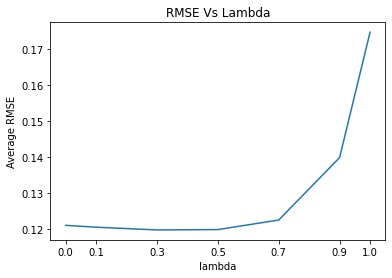

In [202]:
figure_3_experiment()

### Balanced train set

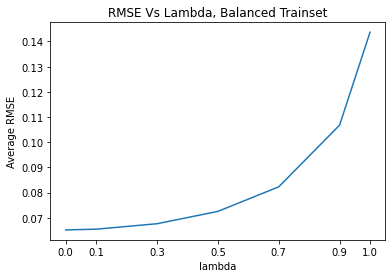

In [203]:
figure_3_experiment_balanced()

# Experiment Figure 4&5 

train_data_full_set = generate_n_seq_training_set(1000)
start = timeit.default_timer()
alpha = np.linspace(0,0.6,61)
lba = np.linspace(0,1,11)
rmse_matrix = np.zeros((len(alpha)*len(lba),3))
run = 0
for a in np.nditer(alpha):
    for l in np.nditer(lba):
        rmse_matrix[run,0] = a
        rmse_matrix[run,1] = l
        rmse_matrix[run,2] = figure_4_experiment_per_alpha_lambda(l,a,train_data_full_set)
        run = run +1
        #print('training with lambda:',l,'alpha:', a)
rmsedf = pd.DataFrame(data=rmse_matrix, columns=["alpha", "lambda","rmse"])
end = timeit.default_timer()
#print('time_elapsed:', end-start)

In [211]:
rmsedf = figure_4_experiment()

## Experiment Figure 4

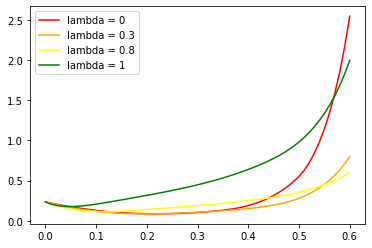

In [213]:
plt.plot( 'alpha', 'rmse', data=rmsedf[rmsedf['lambda'] == 0], color='red',label = 'lambda = 0')
plt.plot( 'alpha', 'rmse', data=rmsedf[rmsedf['lambda'] == 0.30000000000000004], color='orange',label = 'lambda = 0.3')
plt.plot( 'alpha', 'rmse', data=rmsedf[rmsedf['lambda'] == 0.8], color='yellow',label = 'lambda = 0.8')
plt.plot( 'alpha', 'rmse', data=rmsedf[rmsedf['lambda'] == 1], color='green',label = 'lambda = 1')
plt.legend()

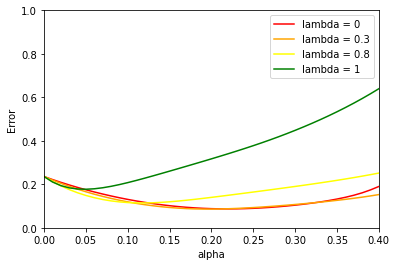

In [214]:
plt.plot( 'alpha', 'rmse', data=rmsedf[rmsedf['lambda'] == 0], color='red',label = 'lambda = 0')
plt.plot( 'alpha', 'rmse', data=rmsedf[rmsedf['lambda'] == 0.30000000000000004], color='orange',label = 'lambda = 0.3')
plt.plot( 'alpha', 'rmse', data=rmsedf[rmsedf['lambda'] == 0.8], color='yellow',label = 'lambda = 0.8')
plt.plot( 'alpha', 'rmse', data=rmsedf[rmsedf['lambda'] == 1], color='green',label = 'lambda = 1')
plt.xlim(0,0.4)
plt.ylim(0,1)
plt.xlabel('alpha')
plt.ylabel('Error')
plt.legend()

## Experiment Figure 5 

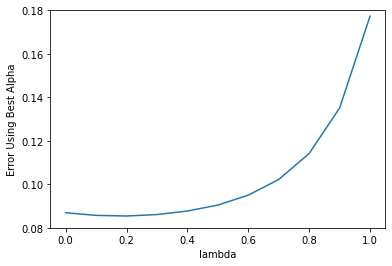

In [215]:
best_alpha = rmsedf.groupby("lambda")['rmse'].min().to_frame()
best_alpha.reset_index(level=0, inplace=True)

plt.plot('lambda', 'rmse', data=best_alpha)
plt.ylim(0.08,0.18)
plt.xlabel('lambda')
plt.ylabel('Error Using Best Alpha')
plt.show()